### Ruoff Regularisation

- c, d) Heatmaps successful fits per regularisation strength, by noise and sparsity
- Supplement

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sys
from pathlib import Path
sys.path.append(str(Path(".").resolve().parent))

from helpers_ruoff import load_exp_summary

dir_pipeline = Path(".").resolve().parents[1]
output_path = Path(".") / "Fig5"
output_path.mkdir(exist_ok=True)

In [3]:
CLUSTER = False

# set paths
if CLUSTER:
    storage_dir = Path("/storage/groups/hasenauer_lab/sym/").resolve()
    dir_5 = storage_dir / "5_optimisation"
    dir_sim = storage_dir / "6_evaluation" / "simulation"
else:
    dir_5 = dir_pipeline / "5_optimisation"

In [4]:
# load both summary files

problem_name = "ruoff_atp_consumption"
experiment_name_grid = "2024_07_22_Ruoff_Grid"
experiment_name_25 = "2024_08_13_Ruoff_Grid"

summary_grid = load_exp_summary(dir_5 / experiment_name_grid)
summary_25 = load_exp_summary(dir_5 / experiment_name_25)
# combine
summary = pd.concat([summary_25, summary_grid])

In [5]:
# add reg bins
bins = [-1, 1e-4,    1e-2,  1e-1,   1,   10]
labels_5_bins = ["0", "<0.01", "<0.1", "<1", "<10"]
summary["regbin"] = pd.cut(summary['λ_reg'], bins=bins, labels=labels_5_bins)

# add success
metric = 'nmae_obs_test'
threshold = 0.15
summary["success"] = summary[metric] <= threshold

/tmp/ipykernel_1188829/3757754338.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = summary.groupby([hp, "regbin"])["success"].sum().reset_index().pivot(
/tmp/ipykernel_1188829/3757754338.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels([f'{round(i*100)}%' for i in colorbar.get_ticks()])
/tmp/ipykernel_1188829/3757754338.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = summary.groupby([hp, "regbin"])["success"].sum().reset_index().pivot(
/tmp/ipykernel_1188829/375775

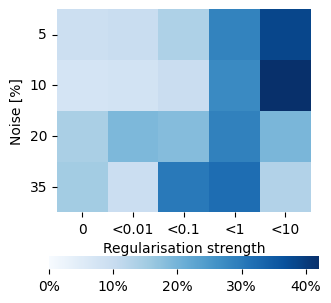

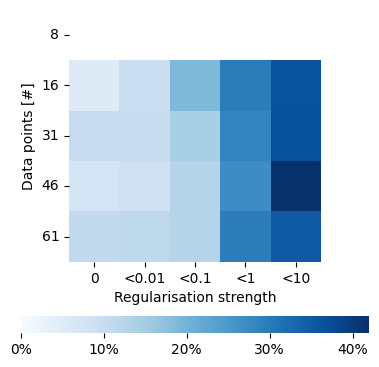

In [6]:
# heatmap success

for hp, hp_label, figsize in zip(["noise_level", "ndp"], ["Noise [%]", "Data points [#]"], [(3.3, 3.2), (3.9, 3.9)]):

    pivot_table = summary.groupby([hp, "regbin"])["success"].sum().reset_index().pivot(
        index=hp, columns="regbin", values="success"
    )[labels_5_bins]
    row_sum = pivot_table.sum(axis=1)
    pivot_table = pivot_table.apply(lambda x: x/row_sum, axis=0)

    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
        pivot_table,
        # annot=True,
        # fmt=".0%",
        cmap="Blues",
        ax=ax,
        cbar_kws={
            # 'format': '.0%',
            "orientation": "horizontal",
        },
        square=True,
        vmin=0, vmax=0.42,
    )
    # Update annotations with percentage sign
    #for text in ax.texts:
    #    text.set_text(text.get_text() + '%')

    colorbar = ax.collections[0].colorbar
    # colorbar.set_ticks(colorbar.get_ticks())
    colorbar.set_ticklabels([f'{round(i*100)}%' for i in colorbar.get_ticks()])

    plt.yticks(rotation=0) 
    ax.set(xlabel="Regularisation strength", ylabel=hp_label)
    # fig.suptitle("Successful fits by regularisation strength")

    fig.tight_layout()
    fp_output = output_path / f"{hp}_heatmap_success.svg"
    fig.savefig(fp_output, transparent=True)

### Supplement: Successful fits by regularisation strength

In [118]:
noise = 20
ndp = 61
df = summary.query("noise_level == @noise & (ndp == @ndp)")
dir_exp_output = dir_5 / experiment_name_grid

/tmp/ipykernel_773329/3289206673.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


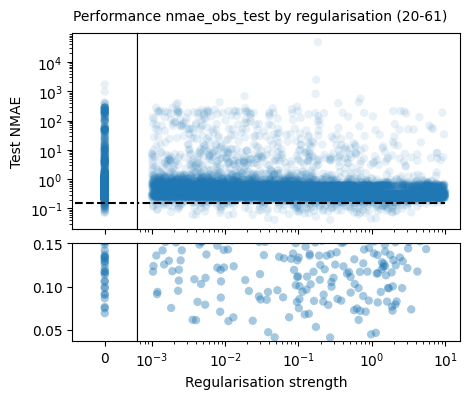

In [114]:
# scatter plot metric by reg.
fig, ax = plt.subplots(
    figsize=(5,4),
    nrows=2, ncols=2, 
    gridspec_kw={
        'width_ratios': [1, 5], 
        'height_ratios': [2, 1],
        'wspace': 0, 'hspace': 0.1,
    },
    sharex="col", sharey="row",
)
fig.suptitle(
    f"Performance {metric} by regularisation ({noise}-{ndp})", 
    fontsize="medium", y=0.94,
)
# no regularisation
df0 = df.query("λ_reg == 0")
ax[0, 0].scatter(df0["λ_reg"], df0[metric], alpha=0.1, edgecolor="none")
ax[1, 0].scatter(df0["λ_reg"], df0[metric], alpha=0.4, edgecolor="none")
# reg on log scale
ax[0, 1].scatter(df["λ_reg"], df[metric], alpha=0.1, edgecolor="none")
ax[1, 1].scatter(df["λ_reg"], df[metric], alpha=0.4, edgecolor="none")
ax[1, 1].set_ylim(0.9 * df[metric].min(), threshold)
# add a horizontal line
ax[0, 0].hlines(threshold, -0.01, 0.01, linestyle="dashed", color="k")
ax[0, 1].hlines(threshold, 0, 1e1, linestyle="dashed", color="k")
# scale
for axis in ax[0, :]:
    axis.set_yscale("log")
for axis in ax[:, 1]:
    axis.set_xscale("log")
    axis.tick_params(left=False, which="both")
ax[1,0].set_xticks(ticks=[0], labels=[0])
# labeling
ax[1, 1].set_xlabel("Regularisation strength", x=0.4)
ax[0, 0].set_ylabel("Test NMAE")
# save
fig.tight_layout()
fig.savefig(output_path / f"{noise}_{ndp}_scatter_{metric}_by_reg.svg", transparent=True)

/tmp/ipykernel_773329/2028428055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bin2plot"] = pd.cut(df['λ_reg'], bins=bins, labels=labels)
/tmp/ipykernel_773329/2028428055.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(i, 3) for i in bin_mids])


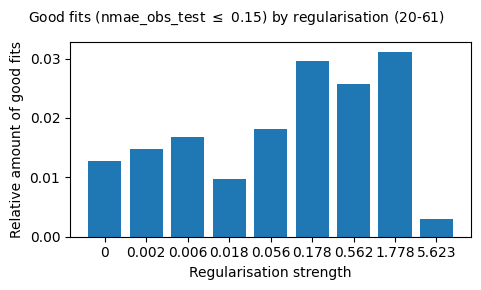

In [142]:
nbins = 8

bins = np.concatenate([[-1], np.power(10, np.linspace(-3, 1, nbins+1))])
bin_mids = [0] + list(np.power(10, np.linspace(-3, 1, nbins+1) + 0.25)[:-1])
labels = ["0"] + [str(b) for b in bins][1:-1]
df["bin2plot"] = pd.cut(df['λ_reg'], bins=bins, labels=labels)
df_ = df[df[metric] <= threshold]
# load all experiments
dfsetup = pd.read_csv(
    dir_exp_output / "experiment_summary.csv"
).query("noise_level == @noise & (sparsity == @sparsity)")
dfsetup["bin2plot"] = pd.cut(dfsetup['λ_reg'], bins=bins, labels=labels)
def div_by_3(s):
    if "3" in s:
        return str(round(float(s), 3))
    else:
        return s
# plot
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(labels, df_["bin2plot"].value_counts() / dfsetup["bin2plot"].value_counts())
fig.suptitle(
    f"Good fits ({metric} $\leq$ {threshold}) by regularisation ({noise}-{ndp})", 
    fontsize="medium", y=0.95,
)
ax.set_xlabel("Regularisation strength")
ax.set_ylabel("Relative amount of good fits")
ax.set_xticklabels([round(i, 3) for i in bin_mids])
# save
fig.tight_layout()
fig.savefig(
    output_path / f"{noise}_{ndp}_hist_{metric}_{threshold}_by_reg_rel.svg", 
    transparent=True,
)